

#  Verifying the findchirp algorithm for GW150914 using the best fit template values as derived by the [PyCBCInspiral](https://github.com/gwastro/pycbc/blob/master/examples/gw150914/PyCBCInspiral.ipynb) example


This flow of work is inspired by the GWOSC tutorials. We will be using the [PyCBC](http://github.com/gwastro/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data

## Installation (execute only if running on a cloud platform!)

In [ ]:
# -- Use the following for Google Colab
! pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.2

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

### Significance of Virgo SNR peak of GW150914 ###

We will consider a gravitational wave signal, whose existence has been confirmed based on the signals from LIGO detectors alone. This was in fact the case for the matched-filtering based analyses of GW150914, as they did not incorporate any information from the Virgo data.

We ask ourselves the following question: *What is the probability that noise can produce a peak as large or larger than the largest peak observed in the Virgo data, and consistent with the lightspeed travel time between all three observatories?*

This is a form of null hypothesis testing, where we compute a [p-value](https://en.wikipedia.org/wiki/P-value) to answer the question above.

<!-- For the purpose of this notebook, we have added a few additional simplifying assumptions, and those will be stated as we go along. -->

#### Read and Precondition Gravitational Strain Data ####

In this section, we will read in a short segment of data around GW170814, and do some basic preconditioning as demonstrated in previous tutorials. We will also calculate the power spectrum of the data.

Notably, here we assume that the power spectrum estimated from the data is constant over the short stretch of time, and isn't biased by our choice to center the estimate (very roughly) on the event time. We *do not* assume the data to be stationary, Gaussian, or free from non-astrophysical transient artefacts.

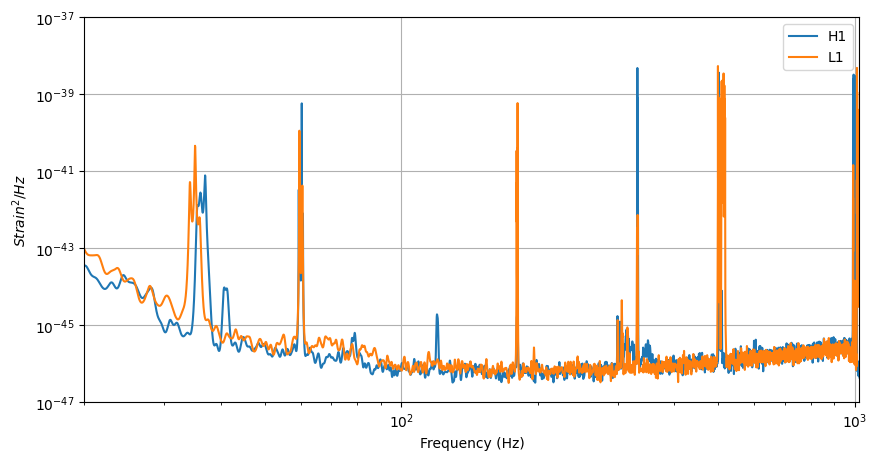

In [ ]:
import pylab

from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

m = Merger("GW150914")

ifos = ['H1', 'L1']
data = {}
psd = {}

pylab.figure(figsize=[10, 5])

for ifo in ifos:
    # Read in and precondition the data
    ts = m.strain(ifo).highpass_fir(15, 512)
    data[ifo] = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

    # Estimate the power spectral density of the data
    # This chooses to use 2s samples in the PSD estimate.
    # One should note that the tradeoff in segment length is that
    # resolving narrow lines becomes more difficult.
    p = data[ifo].psd(2)
    p = interpolate(p, data[ifo].delta_f)
    p = inverse_spectrum_truncation(p, int(2 * data[ifo].sample_rate), low_frequency_cutoff=15.0)
    psd[ifo] = p

    pylab.plot(psd[ifo].sample_frequencies, psd[ifo], label=ifo)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-47, 1e-37)
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

#### Generate our template waveform and calculate the Signal-to-noise time series ####

To calculate the signal-to-noise time series, we need to generate an estimate of the signal to use as a template. For this purpose we will assume the source black holes are non spinning, have equal mass, and they agree with the total mass estimate for the system as a whole. A better method would be to use the maximum likelihood estimate from an analysis of the LIGO data alone, however, this is sufficient for the purposes of this tutorial.

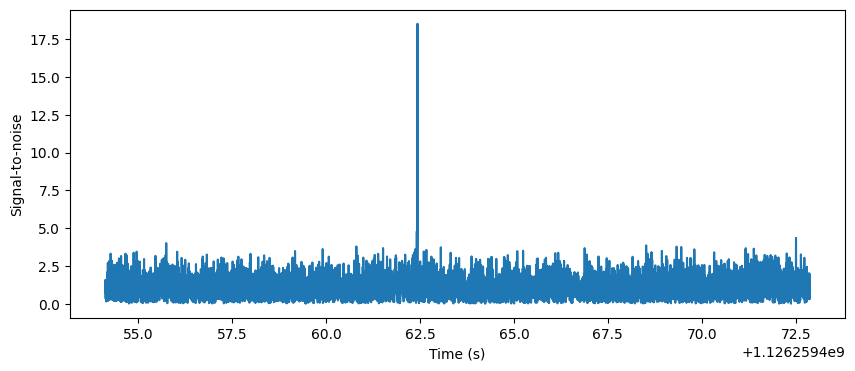

We found a signal at 1126259462.4345703s with SNR 18.52886829358742


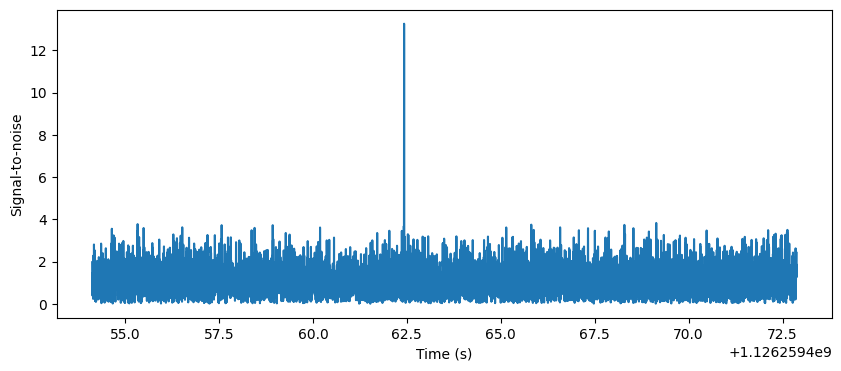

We found a signal at 1126259462.427246s with SNR 13.26236341780348


In [ ]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

# This is a frequency domain waveform generator. It has a very similar syntax to the time domain
# waveform function used in prior tutorials. This function returns both a plus and a cross
# polarization waveform, but we will just use the plus polarization in building our template
# as these are only different by a phase offset in this specific case.
hp, _ = get_fd_waveform(approximant="IMRPhenomD",mass1=47.9325,mass2=36.597,spin1z=0.961672,spin2z=-0.899665,
                        f_lower=20.0, delta_f=data[ifo].delta_f)
#the above parameters are as derived from the PyCBCInspiral example
hp.resize(len(psd[ifo]))

# For each observatory use this template to calculate the SNR time series
snr = {}
for ifo in ifos:
    snr[ifo] = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=20)
    snr[ifo] = snr[ifo].crop(5, 4)
    pylab.figure(figsize=[10, 4])
    pylab.plot(snr[ifo].sample_times, abs(snr[ifo]))
    # Why are we taking an abs() here?
    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion corresponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be
    # anything, we choose to maximize over the phase of the signal.
    pylab.ylabel('Signal-to-noise')
    pylab.xlabel('Time (s)')
    pylab.show()

    peak = abs(snr[ifo]).numpy().argmax()
    snrp = snr[ifo][peak]
    time = snr[ifo].sample_times[peak]

    print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

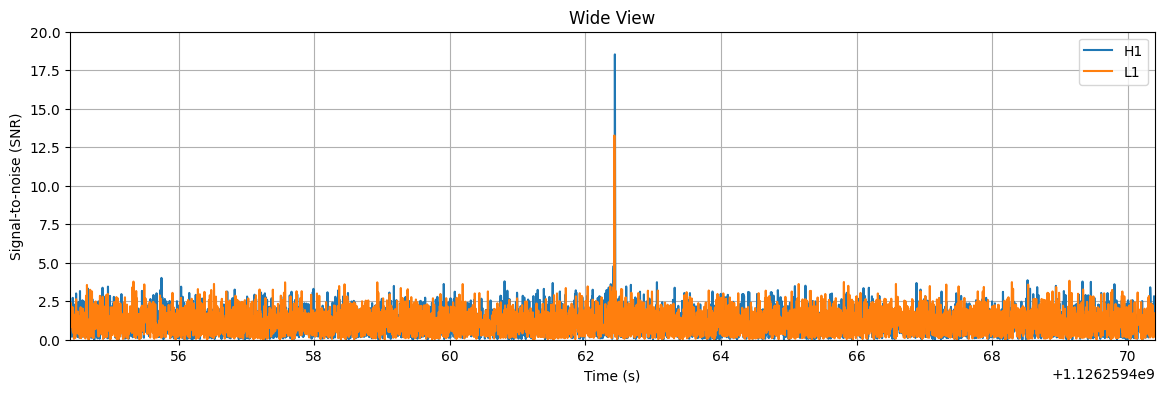

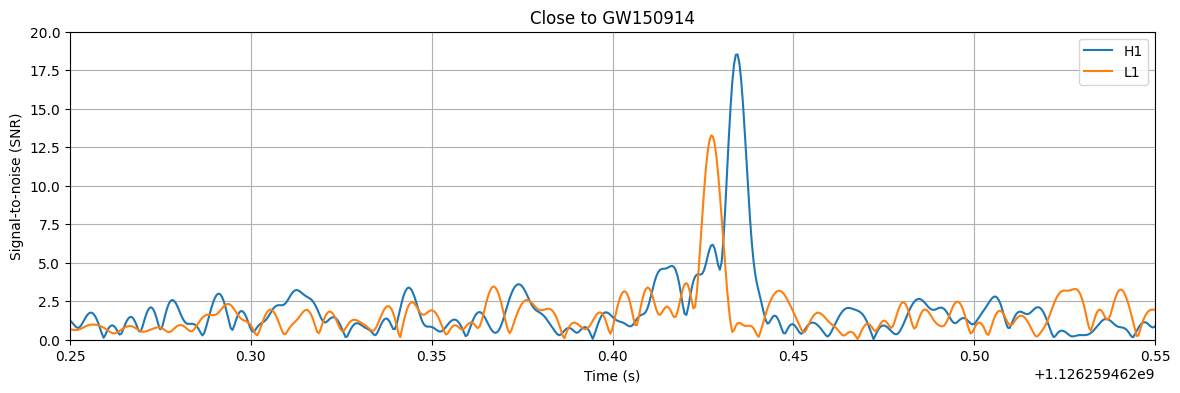

In [ ]:
# Show a couple sizes
for w, title in [(8, 'Wide View'), (.15, 'Close to GW150914')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 20)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()

We see in the SNR time series plots above that while there are nice peaks around GW150914 in each detector, there are also some large peaks at other times. LIGO / Virgo data does contain transient (i.e limited duration) noise artefacts that an analysis must deal with to search LIGO data with high sensitivity. One approach for dealing with this is outlined later in this tutorial.

#### How well is the data actually fitting our model? ####

One of the ways we can test how well the data actual fits the models to use a $\chi^2$-based signal consistency test. We employ a version of the test described [in this paper](https://arxiv.org/pdf/gr-qc/0405045.pdf). Schematically, we chop up our template into $p$ number of frequency bins and see how much the SNR in each individual bin contributes to the total SNR ($\rho_i$) of the supposed signal. The frequency bins are defined such that we expect that there should be a roughly equal contribution to the SNR from each. We can then calculate our statistic as the difference between the SNR in one bin, and the expected fraction of the total SNR ($\rho$).

$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / p)^2
$

This will have $2p-2$ degrees of freedom as each SNR is *complex* representing both possible orthogonal phases the signal could have contributions from. There is also a constraint due to the fact that the sum of each bin must each add up to the total SNR by definition. In this notebook we will normalize this statistic by dividing by the number of degrees of freedom, producing $\chi^2_r$.

We expect that this statistic will be high when the template does not match well with the data, and near unity when the data either is Gaussian noise, or it contains the expected signal in addition to Gaussian noise.

In [ ]:
# WARNING!! If you are having problems with this code, replace the import with
#from pycbc_chisq import power_chisq
from pycbc.vetoes import power_chisq

chisq = {}
for ifo in ifos:
    # The number of bins to use. In principle, this choice is arbitrary. In practice,
    # this is empirically tuned.
    nbins = 26
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, psd[ifo], low_frequency_cutoff=20.0)
    chisq[ifo] = chisq[ifo].crop(5, 4)

    dof = nbins * 2 - 2
    chisq[ifo] /= dof

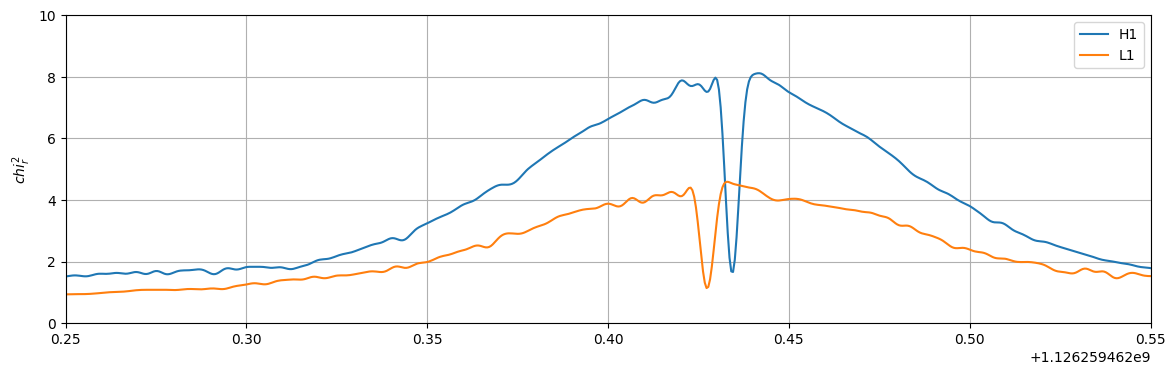

In [ ]:
pylab.figure(figsize=[14, 4])

for ifo in ifos:
    pylab.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo)

pylab.legend()
pylab.grid()
pylab.xlim(m.time -0.15, m.time + 0.15)
pylab.ylim(0, 10)
pylab.ylabel('$chi^2_r$')
pylab.show()

There are some notable features in the $\chi^2_r$ time series. We see that there is a dip in the value at the time of the peak in the SNR in each observatory. We expect this as the template now aligns with the signal in the data. Also, the values climb just around this minima. This occurs because the template is starting to slide against the true signal in the data but is not perfectly aligned with it.

#### Re-weighting our SNR to help down-weight times that don't fit our signal ####

One approach we can take to improve the sensitivity of the search is to down-weight the times where the data does not appear as either Gaussian noise or Gaussian noise + our template. We can do this be combining the SNR time series and our $\chi^2_r$ time series. This is a method used to re-weight the SNR calculated by the PyCBC pipeline since initial LIGO, and has been employed in the first three Advanced LIGO observing runs. In this tutorial we will choose to use the [re-weighted SNR $\hat{\rho}$](https://pycbc.org/pycbc/latest/html/_modules/pycbc/events/ranking.html) ([described in this paper originally](https://iopscience.iop.org/article/10.1088/0264-9381/33/21/215004/pdf), with [more discussion in this work](https://iopscience.iop.org/article/10.1088/1361-6382/ab685e)) to rank our events:

$\hat{\rho} = \frac{\rho}{ \frac{1}{2}[1 + (\chi^2_r)^3]^{1/6}}$ where $\chi^2 > 1$, otherwise $\rho$

For reference on how we rank coincident (i.e. occurring in multiple detector) events in Advanced LIGO, there is a description [here](http://iopscience.iop.org/article/10.3847/1538-4357/aa8f50/pdf).

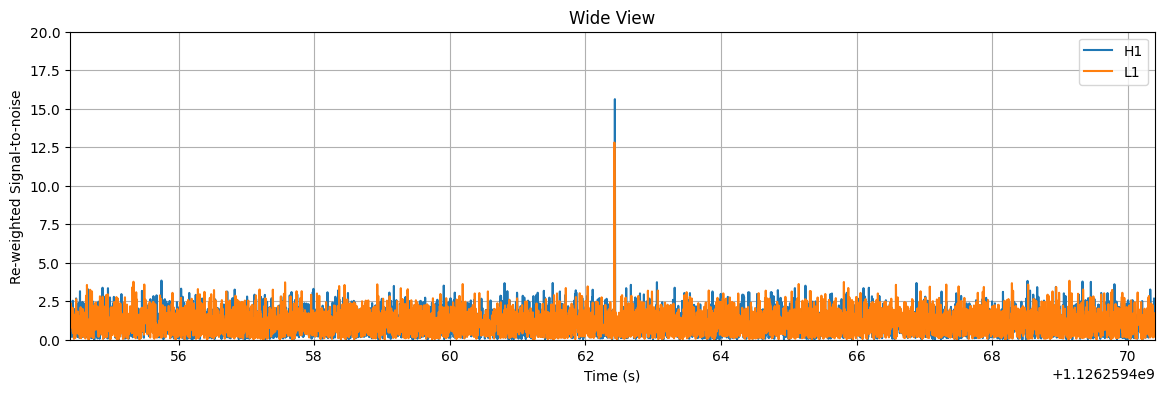

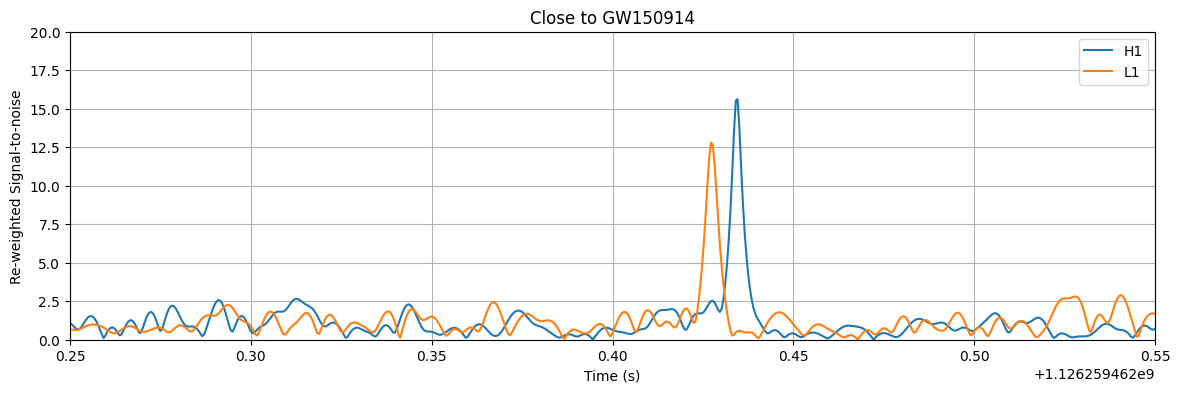

In [ ]:
from pycbc.events.ranking import newsnr

# The rho-hat term above is named "newsnr" here
nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}

# Show a couple sizes
for w, title in [(8, 'Wide View'), (.15, 'Close to GW150914')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 20)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()

We can see above that there are still peaks around GW150914 in all detectors at roughly the same signal strength. At other times - where there were previously peaks in the time series due to transient noise - there are no longer large SNR values.